# SI 618 WN 2018 - Lab 3: Pandorable Analysis

## Objectives
1. Data manipulations: pivot, pivot_tables, stack, unstack, join
2. Introduction to Seaborn
3. Correlation, covariance, ordinary least squares (OLS) regression
4. Chi-square
5. T-tests and ANOVA

## Please fill in...
### * Your name:
### * People you worked with:  [If you didn't work with anyone, write "I worked by myself" here]

## Preface
This lab consists of two parts. Part 1 is based on a comic character dataset and Part 2 uses the U.S. crime dataset.  Part 1 is more focused on analysis of categorical data, and Part 2 analysis of continuous data.

# Part 1: Comic Characters in DC and Marvel

## Description

We need to download ["comic_characters.csv"](https://drive.google.com/open?id=0B1PllrCY3xLZN3ptYnlGRXhybGM) dataset. The original dataset is available at ["Comic Books Are Still Made By Men, For Men And About Men"](http://fivethirtyeight.com/features/women-in-comic-books/).

## Metadata
Here's a description of the fields available in this dataset.

| Field | Description |
| --- | --- |
| publisher | Comic publisher: e.g., DC Comics or Marvel.| 
| name | The name of the character.|
| identity | The identity statusof the character (Secret Identity, Public identity, [on marvel only: No Dual Identity]).|
| align | If the character is Good, Bad or Neutral.|
| eye | Eye color of the character.|
| hair | Hair color of the character.|
| sex | Sex of the character (e.g. Male, Female, etc.)|
| alive | If the character is alive or deceased.|
| appearances | The number of appareances of the character in comic books.|
| first_appearance | The month and year of the character’s first appearance in a comic book, if available.|
| month | The month of the character’s first appearance in a comic book, if available.|
| year | The year of the character’s first appearance in a comic book, if available.|
| date | The date of the character’s first appearance in a comic book, if available.|

## Getting started

First, let's import the NumPy and pandas libraries, and get ready to do some plotting:

In [193]:
import numpy as np
import pandas as pd

Next, we should load the dataset as we did with other datasets before, though this time we use the column "id" as the index as we load our dataframe.

In [196]:
comicCharacters = pd.read_csv("comic_characters.csv", index_col="id")
comicCharacters.head(1)

,publisher,name,Identity,align,eye,hair,sex,alive,appearances,first_appearance,month,year,date
id,,,,,,,,,,,,,
1,Marvel,Spider-Man (Peter Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,Living Characters,4043.0,"1962, August",August,1962.0,8/1/1962


There are two points to consider in the head of the dataframe:
* We have already defined "id" as the index.
* Compare the values in each column and the description of the column in the previous cell.

# Pivot, Pivot Tables, Stack, and Unstack

## Review of Group By

### <font color="magenta">Q1: What is the total number of appearances of characters for each publisher?

In [197]:
a = comicCharacters.groupby('publisher')[['appearances']].sum()
a.head()

,appearances
publisher,
DC,154532.0
Marvel,260270.0


## Unstack

### <font color="magenta">Q2: What is the total number of appearances of characters by each publisher in each year? Output a table.

Comparing this question to Q1, you probably know to group them by both publisher and year.

In [198]:
b = comicCharacters.groupby(['year','publisher']).sum().fillna(0)
b.head()

,,appearances
year,publisher,
1935.0,DC,125.0
1936.0,DC,240.0
1937.0,DC,458.0
1938.0,DC,1639.0
1939.0,DC,4067.0


As you can see from the output, however, it can be hard to compare the number of appearances of characters between the two publishers DC and Marvel. In this case, we can use .unstack() to move the innermost index "publisher" to become the innermost column.

In [200]:
b = comicCharacters.groupby(['year','publisher']).sum().unstack(level=1).fillna(0)
b.head(10)

appearances        
publisher          DC  Marvel
year                         
1935.0          125.0     0.0
1936.0          240.0     0.0
1937.0          458.0     0.0
1938.0         1639.0     0.0
1939.0         4067.0  1013.0
1940.0         9123.0  2160.0
1941.0         6945.0  5371.0
1942.0         4068.0   401.0
1943.0         1475.0   541.0
1944.0          274.0   960.0

As you can see, it is difficult to figure out any trend in appearances of characters of each publisher in each year. However, since you know data visualization, you can plot the time trend for each publisher separately and compare them.

### <font color="magenta">Q3: Plot a time series of appearances over time (one time series for each publisher).

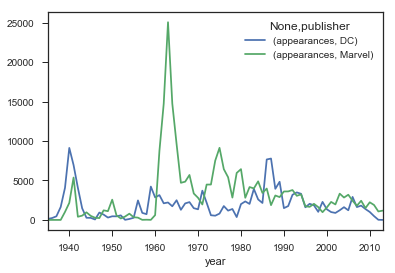

In [201]:
b.plot()

## Pivot Table

### We'd like to know which publisher uses different 'identity' types for their characters? Have DC characters appeared more publicly? What is the average number of times Marvel Characters appeared known to authorities identity?

We can use .groupby() followed by .unstack():

In [351]:
comicCharacters.groupby(['Identity','publisher'])['appearances'].mean().unstack().fillna(0)

publisher,DC,Marvel
Identity,,
Identity Unknown,3.000000,0.000000
Known to Authorities Identity,0.000000,74.400000
No Dual Identity,0.000000,24.402013
Public Identity,28.287166,23.407615
Secret Identity,32.655157,17.379794


Alternatively, we can use .pivot_table(). For example:

In [353]:
#                 Marvel   DC 
# Identity
# Identity Unknown
# No Dual Identity
# ...
avg_appearance_per_identity = comicCharacters.pivot_table(index='Identity', 
                                                          columns='publisher', 
                                                          values='appearances',
                                                          aggfunc='mean')
avg_appearance_per_identity.fillna(0).head()

publisher,DC,Marvel
Identity,,
Identity Unknown,3.000000,0.000000
Known to Authorities Identity,0.000000,74.400000
No Dual Identity,0.000000,24.402013
Public Identity,28.287166,23.407615
Secret Identity,32.655157,17.379794


For .pivot_table(), you need to specify these four arguments:
1. index: the field that will become the index of the output table
2. columns: the field that will become the columns of the output table
3. values: the field to be aggregated/summarized
4. aggfunc: the aggregation operator applied to values, if there are more than 1 entry corresponding to each (index, column) pair, such as "mean", "count", "max"
    

### <font color="magenta">Q4: Which hair color has the biggest difference of total appearances between males and females? Produce the output as a single row from a DataFrame. (Hint: you can subtract a Series from another Series)

To extract such aggregated information from the original table, using .pivot_table would come handy.

In fact, you would like a table that looks like this:



| hair | Male | Female | Absolute Difference |
| --- | --- | --- | --- |
| Black Hair | 10 | 20 | 10 |
| Brown Hair | 35 | 50 | 20 |
| Blond Hair | 40 | 10 | 30 |

In [173]:
hair_gender_diff = comicCharacters.pivot_table(index='hair', 
                                               columns='sex', 
                                               values='appearances',
                                               aggfunc='sum').fillna(0)
hair_gender_diff.head()
hair_gender_diff.apply(lambda x: abs( x['Male Characters'] - x['Female Characters']), axis=1).argmax()


'Brown Hair'

### <font color="magenta">Q5: Are there more Alive/Male characters in DC than Marvel? Do some publishers have more appearances of Living/Transgender versus Agender characters?

### Produce a table that has this information (publisher/gender/living status) that shows the average number of appearances for those character types. Replace all the nulls with 0s.

In [175]:
question_h = comicCharacters.pivot_table(index=['alive', 'sex'], 
                                    columns=['publisher'], 
                                    values='appearances',
                                    aggfunc=np.mean)
question_h.fillna(0)


publisher                                          DC      Marvel
alive               sex                                          
Deceased Characters Agender Characters       0.000000    8.000000
                    Female Characters       19.400000   14.951591
                    Genderless Characters   10.000000    0.000000
                    Male Characters         21.591987   11.867444
                    Transgender Characters   4.000000    0.000000
Living Characters   Agender Characters       0.000000   21.611111
                    Female Characters       23.250497   21.625522
                    Genderfluid Characters   0.000000  282.500000
                    Genderless Characters   13.857143    0.000000
                    Male Characters         25.582198   18.399730

# Categorical Data Analysis: Contingency Table, Mosaic Plot, and $\chi^2$ Test

## Contingency Table

Contigency table is a type of table that displays the frequency distribution of categorical variables. It can be used to depict the interrelation between two variables and help find the interactions between them. For example, to find the interactions between character alignment and alive status:

In [242]:
ct = pd.crosstab(comicCharacters['align'], comicCharacters['alive'])
ct

alive,Deceased Characters,Living Characters
align,,
Bad Characters,2732,6882
Good Characters,1513,5954
Neutral Characters,635,2138
Reformed Criminals,1,2


### <font color="magenta">Q6: Construct a contingency table of sex and character alignment normalized by all values. Display the normalized values in percentage (%) format. Use brief sentences to explain your findings.

In [398]:
ct = pd.crosstab(comicCharacters['sex'], comicCharacters['align'], normalize='all')
ct.apply(lambda x: x.apply(lambda y:  str('{:,.2f}'.format(y*100)) + '%' ))

align,Bad Characters,Good Characters,Neutral Characters,Reformed Criminals
sex,,,,
Agender Characters,0.10%,0.05%,0.07%,0.00%
Female Characters,8.22%,13.01%,4.37%,0.01%
Genderfluid Characters,0.00%,0.01%,0.01%,0.00%
Genderless Characters,0.06%,0.03%,0.02%,0.00%
Male Characters,39.51%,25.13%,9.40%,0.01%
Transgender Characters,0.01%,0.00%,0.00%,0.00%


## Mosaic Plots - Graphical Crosstabs

In addition to using contingency table, we can also use mosaic plot to visually show frequency distributions of categorical variables.

### <font color="magenta">Q7: Create a mosaic plot of character alignment and alive status.

Hint: mosaic(data=..., index=[list of fields], title=...)  

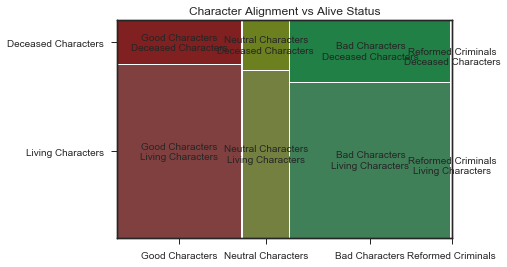

In [238]:
from statsmodels.graphics.mosaicplot import mosaic
t = mosaic(comicCharacters, 
           ['align','alive'], 
           title='Character Alignment vs Alive Status')

## $\chi^2$ Test

The contingency table and mosiac plot can show interrelation between categorical variables. If we want to further measure the significance of the interrelation, we can use chi-squared test.

### <font color="magenta">Q8: Conduct a $\chi^2$ test of ```align``` and ```alive```. Please specify your (null and alternative) hypotheses and explain your findings.

In [245]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(ct)
print("chi2 = ", chi2)
print("p-val = ", p)
print("degree of freedom = ",dof)
print("Expected:")
pd.DataFrame(ex, index=ct.index, columns=ct.columns)

chi2 =  155.776736098
p-val =  1.49439181714e-33
degree of freedom =  3
Expected:


alive,Deceased Characters,Living Characters
align,,
Bad Characters,2363.193534,7250.806466
Good Characters,1835.444780,5631.555220
Neutral Characters,681.624263,2091.375737
Reformed Criminals,0.737423,2.262577


## One-Way Analysis of Variance (ANOVA)

One-way ANOVA is used to test null hypothesis that samples are drawn from populations with same mean values, therefore capable of detecting mean differences between two or more samples.

### <font color="magenta">Q9: Conduct a one-way ANOVA to compare means of appearances of difference character alignments. Please specify your (null and alternative) hypotheses and explain your findings.

In [337]:
comic_characters['align'].unique()

array(['Good Characters', 'Neutral Characters', 'Bad Characters', nan,
       'Reformed Criminals'], dtype=object)

Hint:
1. First, split data into different groups
2. Then, use stats.f_oneway(group1, group2, ...)

In [347]:
good_characters = comic_characters[comic_characters['align'] == 'Good Characters']
neutral_characters = comic_characters[comic_characters['align'] == 'Neutral Characters']
bad_characters = comic_characters[comic_characters['align'] == 'Bad Characters']
reformed_criminals = comic_characters[comic_characters['align'] == 'Reformed Criminals']

stats.f_oneway(good_characters.appearances.dropna(), 
               neutral_characters.appearances.dropna(), 
               bad_characters.appearances.dropna(),
               reformed_criminals.appearances.dropna())

F_onewayResult(statistic=95.60065301835094, pvalue=2.1028273381789163e-61)

# Part 2: Analysis of US Crime Data

Reference: Venables, W. N. and Ripley, B. D. (1999) Modern Applied Statistics with S-PLUS. Third Edition. Springer.

## Description

Criminologists are interested in the effect of punishment regimes on crime rates. This has been studied using aggregate data on 47 states of the USA for 1960 given in this data frame. The variables seem to have been re-scaled to convenient numbers.

## Metadata

This data frame contains the following columns:


| Field | Description |
| --- | --- |
| M | percentage of males aged 14–24. |
| So | indicator variable for a Southern state.|
| Ed | mean years of schooling.| 
| Po1| police expenditure in 1960.| 
| Po2| police expenditure in 1959.| 
| LF | labour force participation rate.| 
| M.F| number of males per 1000 females.| 
| Pop| state population.| 
| NW| number of non-whites per 1000 people.| 
| U1| unemployment rate of urban males 14–24.| 
| U2| unemployment rate of urban males 35–39.| 
| GDP| gross domestic product per head.| 
| Ineq | income inequality.| 
| Prob| probability of imprisonment.| 
| Time| average time served in state prisons.| 
| y| rate of crimes in a particular category per head of population.| 



In [441]:
UScrime = pd.read_csv("UScrime.csv")
UScrime.head()

,Unnamed: 0,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,GDP,Ineq,Prob,Time,y
0,1,151,1,91,58,56,510,950,33,301,108,41,394,261,0.084602,26.2011,791
1,2,143,0,113,103,95,583,1012,13,102,96,36,557,194,0.029599,25.2999,1635
2,3,142,1,89,45,44,533,969,18,219,94,33,318,250,0.083401,24.3006,578
3,4,136,0,121,149,141,577,994,157,80,102,39,673,167,0.015801,29.9012,1969
4,5,141,0,121,109,101,591,985,18,30,91,20,578,174,0.041399,21.2998,1234


# Visualization using Seaborn

In [264]:
import seaborn as sns
%matplotlib inline

## Histogram

### <font color="magenta">Q10: Create a histogram of the GDP field.

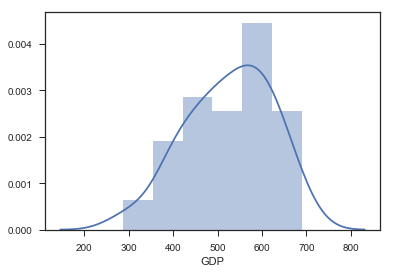

In [415]:
sns.distplot(UScrime['GDP'])

## Boxplot

Alternatively, you can use boxplot to depict the dispersion of the same distribution, with the ```orient='v'``` parameter to display the plot vertically

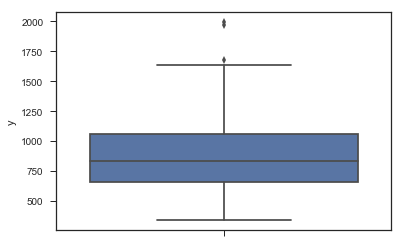

In [404]:
sns.boxplot(UScrime.y, orient='v')

### <font color="magenta">Q11: Create a vertical boxplot of crime rate per capita ```y``` grouped by the indicator variable ```So``` (if a state is Southern or Northern state).

Hint: Use ```y=``` to specify the field of interest, and ```x=``` to specify the grouping field

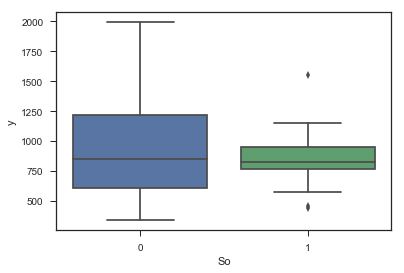

In [266]:
sns.boxplot(x="So", y="y", data=UScrime)

### <font color="magenta">Q12: Create a scatter plot of crime rate per capita ```y``` vs. ```GDP``` with fitted regression line and marginal histogram plots.

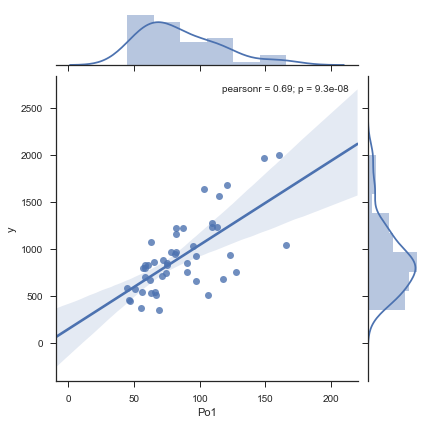

In [407]:
g = sns.JointGrid(x='GDP',y='y', data=UScrime)
g = g.plot(sns.regplot, sns.distplot)
g = g.annotate(stats.pearsonr)


## Correlation

### <font color="magenta">Q13: What is the correlation between GDP and Income Inequality?

In [272]:
UScrime.GDP.corr(UScrime['Ineq'])

-0.88399727579985121

### <font color="magenta">Q14: What is the correlation between every pair of variables?

In [304]:
correlation = UScrime.corr()
correlation

,Unnamed: 0,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,GDP,Ineq,Prob,Time,y
Unnamed: 0,1.000000,0.119596,-0.059583,-0.050313,-0.153433,-0.163304,0.000196,0.175781,-0.071130,-0.196049,0.116435,0.030225,-0.028426,-0.028255,-0.072332,0.022777,-0.271133
M,0.119596,1.000000,0.584355,-0.530240,-0.505737,-0.513173,-0.160949,-0.028680,-0.280638,0.593198,-0.224381,-0.244843,-0.670055,0.639211,0.361116,0.114511,-0.089472
So,-0.059583,0.584355,1.000000,-0.702741,-0.372636,-0.376168,-0.505469,-0.314733,-0.049918,0.767103,-0.172419,0.071693,-0.636945,0.737181,0.530862,0.066813,-0.090637
Ed,-0.050313,-0.530240,-0.702741,1.000000,0.482952,0.499410,0.561178,0.436915,-0.017227,-0.664882,0.018103,-0.215682,0.735997,-0.768658,-0.389923,-0.253974,0.322835
Po1,-0.153433,-0.505737,-0.372636,0.482952,1.000000,0.993586,0.121493,0.033760,0.526284,-0.213709,-0.043698,0.185093,0.787225,-0.630500,-0.473247,0.103358,0.687604
Po2,-0.163304,-0.513173,-0.376168,0.499410,0.993586,1.000000,0.106350,0.022843,0.513789,-0.218768,-0.051712,0.169224,0.794262,-0.648152,-0.473027,0.075627,0.666714
LF,0.000196,-0.160949,-0.505469,0.561178,0.121493,0.106350,1.000000,0.513559,-0.123672,-0.341214,-0.229400,-0.420762,0.294632,-0.269886,-0.250086,-0.123640,0.188866
M.F,0.175781,-0.028680,-0.314733,0.436915,0.033760,0.022843,0.513559,1.000000,-0.410628,-0.327305,0.351892,-0.018692,0.179609,-0.167089,-0.050858,-0.427697,0.213914
Pop,-0.071130,-0.280638,-0.049918,-0.017227,0.526284,0.513789,-0.123672,-0.410628,1.000000,0.095153,-0.038120,0.270422,0.308263,-0.126294,-0.347289,0.464210,0.337474
NW,-0.196049,0.593198,0.767103,-0.664882,-0.213709,-0.218768,-0.341214,-0.327305,0.095153,1.000000,-0.156450,0.080908,-0.590107,0.677313,0.428059,0.230398,0.032599


### <font color="magenta">Q15: Find the top 5 variables that has the highest correlation with crime rate per capita (excluding y itself). Save the output list as 'top5_correlated_variables'.

In [328]:
top5_correlated_variables = abs(correlation).sort_values('y', ascending=False).head(6).index[1:].values.tolist()
top5_correlated_variables

['Po1', 'Po2', 'GDP', 'Prob', 'Pop']

## PairPlot

And now create a pairplot to visualize the relationships between the six columns

### <font color="magenta">Q16: Create a pairplot to show the pair-wise correlations of crime rate per capita plus the top5_correlated_variables.

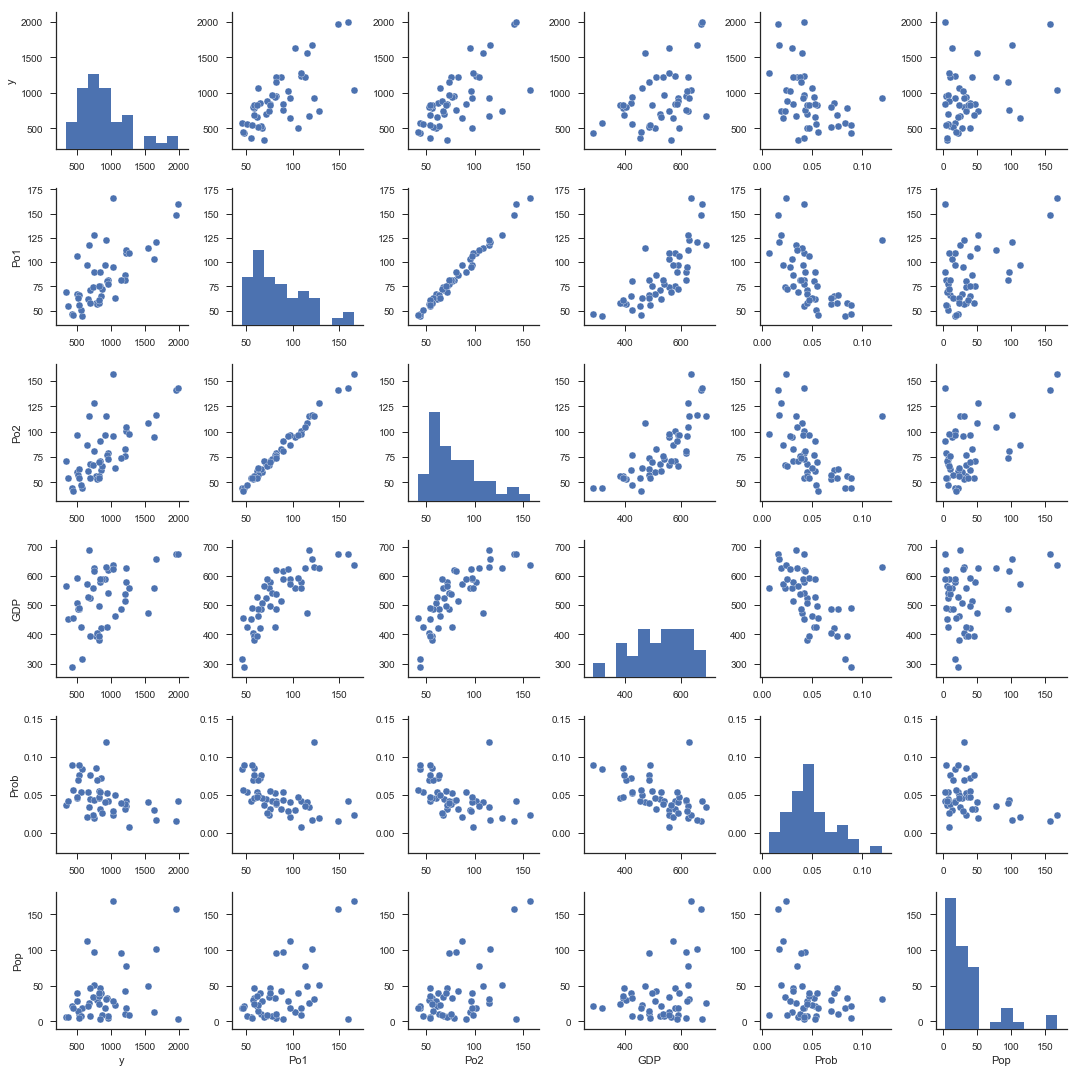

In [329]:
sns.pairplot(UScrime[['y'] + top5_correlated_variables])

## Pearson's r, Kendall's tau, Spearman's rho

Rules of Thumb:

1. We would prefer to use ***Pearson's r*** when

           1) we know the two variables follow a bivariate normal distribution;
   
       AND 2) the relationship between the two variables is linear.
       
       AND 3) the error terms of the regression are constant and not dependent on x-value

2. We would prefer to use ***Kendall's tau*** and ***Spearman's rho*** when

            1) we do not know if there holds the normal assumption about the data;

        OR  2) the relationship between the two variables is non-linear;

        OR  2) there are highly influential outliers;

        OR  3) the data is highly skewed

### <font color="magenta">Q17: Compute the correlations between crime rate per capita (y) and GDP using Pearson's r, Kendall's tau, Spearman's rho.

In [293]:
from scipy import stats

Hint:
    1. stats.pearsonr(.., ..)
    2. stats.kendalltau(.., ..)
    3. stats.spearmanr(.., ..)
    4. all three functions return the correlation and its associated p-value

In [292]:
r, p_value = stats.pearsonr(UScrime['y'], UScrime['GDP'])
print("Pearson's r:",r,p_value)
tau, p_value = stats.kendalltau(UScrime['y'], UScrime['GDP'])
print("Kendall's tau:",tau,p_value)
correlation,pvalue = stats.spearmanr(UScrime['y'], UScrime['GDP'])
print("Spearman's rho:",correlation,pvalue)

Pearson's r: 0.441319948973 0.00190166929379
Kendall's tau: 0.292728146268 0.0037527684575
Spearman's rho: 0.399838098985 0.00536050207883


## Ordinary Least Squares (OLS) Regression

In [307]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

### <font color="magenta">Q18: Regress crime rate per capita on the top5_correlated_variables. Which explanatory variables are statistically significant?

In [435]:
model1 = smf.ols('y ~ ' + '+'.join(top5_correlated_variables), data=UScrime).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     12.56
Date:                Sun, 28 Jan 2018   Prob (F-statistic):           8.29e-07
Time:                        21:05:14   Log-Likelihood:                -327.71
No. Observations:                  47   AIC:                             665.4
Df Residuals:                      42   BIC:                             674.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    849.8077    342.751      2.479      0.017     158.107    1541.508
Po1           24.2491     12.000      2.021      0.050       0.033      48.465
Po2          -14.1238     12.938     -1.092      0.281     -40.235      11.987
GDP           -1.3353      0.730     -1.830      0.074      -2.808       0.137
Prob       -3633.8717   2135.990     -1.701      0.096   -7944.473     676.730
==============================================================================
Omnibus:                        2.761   Durbin-Watson:                   2.266
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                1.936
Skew:                          -0.482   Prob(JB):                        0.380
Kurtosis:                       3.245   Cond. No.                     2.95e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.95e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now if you want to compare the per unit contribution of each variable to crime rate per capita, you would need to normalize the variables so that their values are on the same scale and are comparable.

In [453]:
from IPython.display import Image
from IPython.core.display import HTML 

There are different ways of normalization, and the two popular methods are:
    1. Min-Max Scaling
    2. Standardization

Here we use Min-Max Scaling:

In [449]:
UScrime[top5_correlated_variables] = UScrime[top5_correlated_variables].apply(lambda x: 
                                                                              (x-np.min(x)) / (np.max(x)-np.min(x)), axis=0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     12.56
Date:                Sun, 28 Jan 2018   Prob (F-statistic):           8.29e-07
Time:                        21:20:36   Log-Likelihood:                -327.71
No. Observations:                  47   AIC:                             665.4
Df Residuals:                      42   BIC:                             674.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    952.2911    187.663      5.074      0.000     573.572    1331.010
Po1         2934.1359   1451.945      2.021      0.050       3.992    5864.279
Po2        -1638.3579   1500.863     -1.092      0.281   -4667.223    1390.507
GDP         -535.4682    292.638     -1.830      0.074   -1126.036      55.099
Prob        -410.2787    241.162     -1.701      0.096    -896.963      76.405
==============================================================================
Omnibus:                        2.761   Durbin-Watson:                   2.266
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                1.936
Skew:                          -0.482   Prob(JB):                        0.380
Kurtosis:                       3.245   Cond. No.                         68.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### <font color="magenta">Q19: Build the regression model with the same variables again. Comparing the result to the previous model, what have changed and what have not changed?

In [452]:
model2 = smf.ols('y ~ ' + '+'.join(top5_correlated_variables), data=UScrime).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     12.56
Date:                Sun, 28 Jan 2018   Prob (F-statistic):           8.29e-07
Time:                        21:30:33   Log-Likelihood:                -327.71
No. Observations:                  47   AIC:                             665.4
Df Residuals:                      42   BIC:                             674.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    952.2911    187.663      5.074      0.000     573.572    1331.010
Po1         2934.1359   1451.945      2.021      0.050       3.992    5864.279
Po2        -1638.3579   1500.863     -1.092      0.281   -4667.223    1390.507
GDP         -535.4682    292.638     -1.830      0.074   -1126.036      55.099
Prob        -410.2787    241.162     -1.701      0.096    -896.963      76.405
==============================================================================
Omnibus:                        2.761   Durbin-Watson:                   2.266
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                1.936
Skew:                          -0.482   Prob(JB):                        0.380
Kurtosis:                       3.245   Cond. No.                         68.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## T-test

### <font color="magenta">Q20: Conduct a t-test to check if the means of crime rate per capit are equal for Southern and Northern state. Please specify your (null and alternative) hypotheses and explain your findings.

Hint: stats.ttest_ind()

In [297]:
stats.ttest_ind(UScrime[UScrime.So==0]['y'].dropna(), UScrime[UScrime.So==1]['y'].dropna())

Ttest_indResult(statistic=0.61052412168950276, pvalue=0.5445860096828905)